In [1]:
import numpy as np
import torch
from torch import nn, div, square, norm
from torch.nn import functional as F
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time

In [2]:
seed = 42
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(seed)

In [3]:
RATINGS_PATH = 'ml-1m/ratings.csv'
USERS_PATH = 'ml-1m/users.csv'
ITEMS_PATH = 'ml-1m/items.csv'
def load_movielens_1m():
    ratings = pd.read_csv(RATINGS_PATH)
    users = pd.read_csv(USERS_PATH)
    items = pd.read_csv(ITEMS_PATH)
    return ratings, users, items

ratings_df, users_df, items_df = load_movielens_1m()
items_df


,item_id,title,genres,tmdbId
0,0,Toy Story (1995),"['Animation', ""Children's"", 'Comedy']",862.0
1,1,Jumanji (1995),"['Adventure', ""Children's"", 'Fantasy']",8844.0
2,2,Grumpier Old Men (1995),"['Comedy', 'Romance']",15602.0
3,3,Waiting to Exhale (1995),"['Comedy', 'Drama']",31357.0
4,4,Father of the Bride Part II (1995),['Comedy'],11862.0
...,...,...,...,...
3701,3701,Meet the Parents (2000),['Comedy'],1597.0
3702,3702,Requiem for a Dream (2000),['Drama'],641.0
3703,3703,Tigerland (2000),['Drama'],10687.0
3704,3704,Two Family House (2000),['Drama'],63956.0


In [4]:
num_users = users_df['user_id'].max() + 1
num_items = items_df['item_id'].max() + 1
ratings_df

,user_id,item_id,rating,timestamp
0,0,1104,5,978300760
1,0,639,3,978302109
2,0,853,3,978301968
3,0,3177,4,978300275
4,0,2162,5,978824291
...,...,...,...,...
1000204,6039,1019,1,956716541
1000205,6039,1022,5,956704887
1000206,6039,548,5,956704746
1000207,6039,1024,4,956715648


In [5]:
train_ratings, test_ratings = train_test_split(ratings_df,
                                           test_size=0.1,
                                           random_state=seed)

train_mat = torch.zeros((num_users, num_items))
test_mat = torch.zeros((num_users, num_items))
truth_mat = torch.zeros((num_users, num_items))

for row in train_ratings.itertuples(index=False):
    user_id, item_id, rating, *_ = row
    train_mat[user_id , item_id ] = rating
for row in test_ratings.itertuples(index=False):
    user_id, item_id, rating, *_ = row
    test_mat[user_id , item_id ] = rating
for row in ratings_df.itertuples(index=False):
    user_id, item_id, rating, *_ = row
    truth_mat[user_id , item_id ] = rating


In [6]:
truth_mat

tensor([[5., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [3., 0., 0.,  ..., 0., 0., 0.]])

In [7]:
observed_full = truth_mat > 0
observed_test = (test_mat > 0) & observed_full
observed = (train_mat > 0) & observed_full

In [8]:
train_mat[observed].mean()

tensor(3.5814)

In [9]:
# Hyperparameters
num_factors = 100
lr = 0.01
num_epochs = 200
lambda_reg = 0.02

test_rmse_log = []
epochs_log = []

# Initialize latent factors and biases
user_factors = torch.randn(num_users, num_factors) * 0.1
item_factors = torch.randn(num_items, num_factors) * 0.1
user_bias = torch.zeros(num_users) * 0.1
item_bias = torch.zeros(num_items) * 0.1

# Get indices of observed training ratings
train_indices = observed.nonzero(as_tuple=False)  # shape [N, 2]
test_indices = observed_test.nonzero(as_tuple=False)

start_time = time.perf_counter()

for epoch in range(num_epochs):
    # Extract (u, i) pairs
    users = train_indices[:, 0]
    items = train_indices[:, 1]
    ratings = train_mat[users, items]

    # Predictions
    preds = user_bias[users] + item_bias[items] + (user_factors[users] * item_factors[items]).sum(dim=1)
    errors = ratings - preds

    # Compute loss
    total_loss = (errors ** 2).mean().item()

    # Gradients
    grad_user_factors = -2 * (errors[:, None] * item_factors[items]) + 2 * lambda_reg * user_factors[users]
    grad_item_factors = -2 * (errors[:, None] * user_factors[users]) + 2 * lambda_reg * item_factors[items]
    grad_user_bias = -2 * errors + 2 * lambda_reg * user_bias[users]
    grad_item_bias = -2 * errors + 2 * lambda_reg * item_bias[items]

    # Update parameters
    user_factors[users] -= lr * grad_user_factors
    item_factors[items] -= lr * grad_item_factors
    user_bias[users] -= lr * grad_user_bias
    item_bias[items] -= lr * grad_item_bias

    # Compute test RMSE every 10 epochs
    if (epoch + 1) % 10 == 0:
        test_users = test_indices[:, 0]
        test_items = test_indices[:, 1]
        test_ratings = test_mat[test_users, test_items]

        test_preds = user_bias[test_users] + item_bias[test_items] + \
                     (user_factors[test_users] * item_factors[test_items]).sum(dim=1)
        train_time = round(time.perf_counter() - start_time, 4)

        test_rmse = torch.sqrt(((test_ratings - test_preds) ** 2).mean()).item()
        print(f"Epoch {epoch+1}: Train Loss = {total_loss:.4f}, Test RMSE = {test_rmse:.4f}, Training time :{train_time :.2f}")
        test_rmse_log.append(test_rmse)
        epochs_log.append(epoch + 1)


Epoch 10: Train Loss = 7.7148, Test RMSE = 2.7077, Training time :45.10
Epoch 20: Train Loss = 4.9269, Test RMSE = 2.2029, Training time :91.94
Epoch 30: Train Loss = 3.8514, Test RMSE = 1.9603, Training time :150.78
Epoch 40: Train Loss = 3.4378, Test RMSE = 1.8608, Training time :223.04
Epoch 50: Train Loss = 3.2643, Test RMSE = 1.8211, Training time :284.84
Epoch 60: Train Loss = 3.1778, Test RMSE = 1.7949, Training time :345.40
Epoch 70: Train Loss = 3.1305, Test RMSE = 1.7858, Training time :396.75
Epoch 80: Train Loss = 3.1100, Test RMSE = 1.7802, Training time :440.57
Epoch 90: Train Loss = 3.0793, Test RMSE = 1.7691, Training time :486.93
Epoch 100: Train Loss = 3.0691, Test RMSE = 1.7666, Training time :536.57
Epoch 110: Train Loss = 3.0509, Test RMSE = 1.7635, Training time :585.30
Epoch 120: Train Loss = 3.0529, Test RMSE = 1.7640, Training time :636.20
Epoch 130: Train Loss = 3.0403, Test RMSE = 1.7604, Training time :686.63
Epoch 140: Train Loss = 3.0425, Test RMSE = 1.761

In [10]:
user_factors 

tensor([[ 0.0874,  0.2110,  0.0491,  ..., -0.1644,  0.0626,  0.0556],
        [ 0.0579,  0.0143,  0.0948,  ...,  0.0079,  0.0254,  0.1291],
        [ 0.0595,  0.2587, -0.0724,  ..., -0.0199,  0.0699,  0.0767],
        ...,
        [ 0.0254,  0.2044,  0.0706,  ...,  0.2693,  0.0706,  0.2364],
        [-0.0036, -0.0377,  0.2466,  ..., -0.1748,  0.0731, -0.0207],
        [ 0.0526, -0.1113, -0.2557,  ..., -0.0570,  0.0750,  0.0042]])

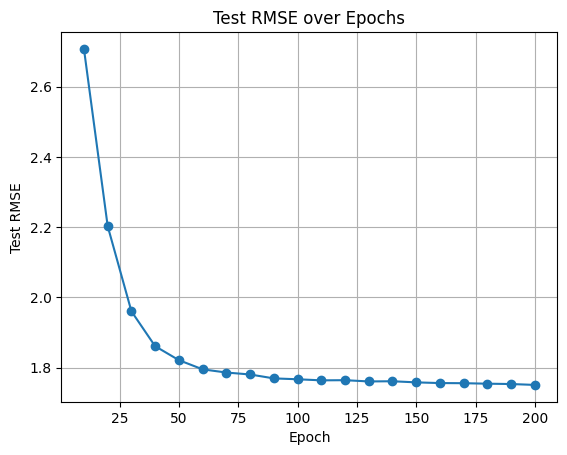

In [11]:
plt.plot(epochs_log, test_rmse_log, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Test RMSE")
plt.title("Test RMSE over Epochs")
plt.grid(True)
plt.show()

In [12]:
full_predict = torch.matmul(user_factors, item_factors.T) + user_bias[:, None] + item_bias[None, :] 
full_predict.shape

torch.Size([6040, 3706])

In [13]:
import numpy as np
import torch

def dcg(relevance_scores):
    return np.sum([
        rel / np.log2(idx + 2) for idx, rel in enumerate(relevance_scores)
    ])

def ndcg_at_k(predicted_indices, ground_truth_ratings_tensor, k=20):
    ground_truth_ratings = ground_truth_ratings_tensor.cpu().numpy()
    top_k_indices = [int(i) for i in predicted_indices[:k]]
    relevance = [ground_truth_ratings[i] for i in top_k_indices]

    dcg_score = dcg(relevance)
    ideal_relevance = sorted(relevance, reverse=True)
    idcg_score = dcg(ideal_relevance)

    if idcg_score == 0:
        return 0.0
    return dcg_score / idcg_score

def mean_ndcg_over_observed_test(full_predict, truth_mat, test_mat, k=20):
    device = full_predict.device
    observed_full = truth_mat > 0
    observed_test = (test_mat > 0) & observed_full

    ndcg_scores = []
    num_users = full_predict.shape[0]

    for user_idx in range(num_users):
        test_items = observed_test[user_idx].nonzero(as_tuple=True)[0]
        if len(test_items) == 0:
            continue 

        user_preds = full_predict[user_idx]
        user_truth = truth_mat[user_idx]

        _, ranked_items = torch.sort(user_preds, descending=True)
        ranked_items = ranked_items.cpu().numpy()

        ndcg = ndcg_at_k(ranked_items, user_truth, k)
        ndcg_scores.append(ndcg)

    if len(ndcg_scores) == 0:
        return 0.0
    return sum(ndcg_scores) / len(ndcg_scores)


In [14]:
full_predict = torch.matmul(user_factors, item_factors.T) + user_bias[:, None] + item_bias[None, :]

k = 20  
mean_ndcg = mean_ndcg_over_observed_test(full_predict, truth_mat, test_mat, k)

print(f"Mean NDCG@{k}: {mean_ndcg:.4f}")

Mean NDCG@20: 0.3070
